<span style="font-family:Papyrus; font-size:3em;">BIOE 437 Homework</span>

<span style="font-family:Papyrus; font-size:2em;">Design of Experiments</span>

# Questions

BioModels model 45 shows bursting behavior of Calcium oscillations using the chemical species ``EC``, ``X``, ``Y``, and ``Z``.
Factors affecting the Ca oscillations include the initial concentrations of these four chemical species.
In this problem, you will find levels of these factors that impact oscillations during the evaluation period of 26s to 38s.
1. ``Y`` has oscillations of at least 1.3 Hz during the evaluation period
1. The "amplitude" (Fourier coefficient) for the oscillations is at least 50.
1. All concentrations of the chemical species are non-negative in the simulation.

There are three parts to answering this question.

1. (20 pts) **Design of Experiments**. What is your experimental design? That is: (a) what is the baseline; (b) what are the factors; (c) what are the levels of the factors; and (d) what $n$WD did you use.
Explain why you chose the particular levels and $n$. It may be that you use a "mixed" strategy in which you
do initial experiments with one design, and based on these outcomes, you do a new design.

1. (60 pts) **Experimental Infrastructure**. Implement the following functions.
As always, you should have documentation and tests for each function.
Note that BioModels 45 is the file ``BIOMD0000000045_url.xml`` in the ``common`` directory. (See code below.)

   1. ``runExperiment`` runs an experiment for levels of initial values of chemical species and returns
   the result of the simulation. The function optionally
   plots the results. 
   1. ``getResponse`` calculates the the
   values of the frequency with the largest amplitude (along with the amplitude) for a chemical species over a
   designated time interval.
   1. ``runStudy`` runs a set of experiments, checking for combinations of factor levels that match the
   objectives of this study.
    
1. (20 pts) **Studies and Analysis**. Describe the studies you conducted, showing how you found a combination of factor levels that meet the requirements.

Please put your answers to these questions in the separate sections below.

# Programming Preliminaries
This section provides the setup to run your python codes along with helpers that you are free to use in your answers.

## Imports

In [1]:
from scipy import fftpack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from SBstoat.namedTimeseries import NamedTimeseries
import tellurium as te
import itertools

## Constants, Model, Helper Functions

In [2]:
roadrunner = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL = roadrunner.getAntimony()
# Simulation constants
START_TIME = 0  # Start time for the simulation
END_TIME = 60  # End time for the simulation
BEGIN_EVAL = 26
END_EVAL = 38
BURST_DCT = {0: (15, 25), 1: (40, 50)}  # Where bursts should be preserved
NUM_POINT = 100*(END_TIME - START_TIME)  # Number of points in output
PARAMETERS = ["X", "Y", "Z", "EC"]
TIME = "time"
ROADRUNNER = te.loada(MODEL)
MODEL_ARR = ROADRUNNER.simulate(START_TIME, END_TIME, NUM_POINT)
print(ROADRUNNER.getAntimony())

// Created by libAntimony v2.13.2
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  beta = 1;
  v2i_

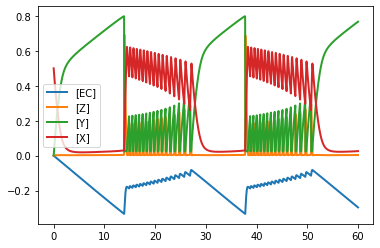

In [3]:
ROADRUNNER.plot(MODEL_ARR)

In [4]:
MODEL_ARR = ROADRUNNER.simulate(START_TIME, END_TIME, NUM_POINT)

In [5]:
def arrToDF(arr):
    """
    Converts a NamedArray to a DataFrame.
    
    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
        index: time
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    return df.set_index(TIME)

# TESTS
rr = te.loada("A -> B; 1; A=0; B=0; a=2")
arr = rr.simulate()
df = arrToDF(arr)
assert(isinstance(df, pd.DataFrame))
trues = ["[" not in c and "]" not in c for c in df.columns]
assert(all(trues))

In [6]:
MODEL_DF = arrToDF(MODEL_ARR)

In [7]:
def filterResponse(df):
    """
    Subsets the dataframe to the period of the evaluation.
    
    Parameters
    ----------
    df: DataFrame
        index: time
        columns: floating species
    
    Returns
    -------
    DataFrame (same structure as input)
    """
    sel = [(v >= 26) and (v <= 38) for v in df.index]
    return df[sel]

# Tests
df = filterResponse(MODEL_DF)
assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


In [8]:
MODEL_EVAL_DF = filterResponse(MODEL_DF)

In [9]:
def calculateFft(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: species
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    MIN_FREQ = 0.5  # Minimum frequency reported
    times = np.array(df.index)
    values = df[molecule].values
    numpt = len(times)
    endTime = times[-1]
    startTime = times[0]
    freqs = list(fftpack.fftfreq(numpt, (endTime-startTime)/numpt))
    values = list(np.abs(fftpack.fft(values)))
    # Eliminate frequency of 0
    new_freqs = []
    new_values = []
    for idx, freq in enumerate(freqs):
        if np.abs(freq) >= MIN_FREQ:
            new_freqs.append(freq)
            new_values.append(values[idx])
    freq_arr = np.array(new_freqs)
    value_arr = np.array(new_values)
    return freq_arr, value_arr

# Tests
freqs, values = calculateFft("X", MODEL_EVAL_DF)
assert(max(values) > 1)  # Top frequency should have a large magnitude
print("OK!")

OK!


In [10]:
def plotFft(molecule, df, ax=None, isPlot=True, **kwargs):
    """
    Plot the FFT for a molecule.
    
    Parameters
    ----------
    df: DataFrame
        index: time
        columns: floating species
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, df=df, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    if not isPlot:
        plt.close()
    
# Tests
plotFft("Y", MODEL_EVAL_DF, isPlot=False)  # "Smoke" test
print("OK!")

OK!


In [11]:
def calculatePeakFrequency(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: floating species
        values: species concentrations
             
    Returns
    -------
    float: peak frequency
    float: amplitude
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        lst1.extend(lst2)
        return np.array(lst1)
    MIN_FREQ = 0.1
    max_delete = 10
    #
    frequencies, amplitudes = calculateFft(molecule, df)
    # Delete the largest N values
    for _ in range(max_delete):
        maxIdx = getIndexOfMax(amplitudes)
        if np.abs(frequencies[maxIdx]) < MIN_FREQ:
            frequencies = deleteArrayElement(frequencies, maxIdx)
            amplitudes = deleteArrayElement(amplitudes, maxIdx)
        else:
            break
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx], amplitudes[maxIdx]

# TESTS
peak_frequency, peak_amplitude = calculatePeakFrequency("Y", MODEL_EVAL_DF)
assert(peak_frequency > 0)
assert(peak_amplitude > 0)
print("OK!")

OK!


# Experimental Design

The experimental design will initially use one factor at a time (1WD) because the combinatorics
are modest.
If this fails, we'll use two factors in combination (2WD).

# Experimental Infrastructure

OK!


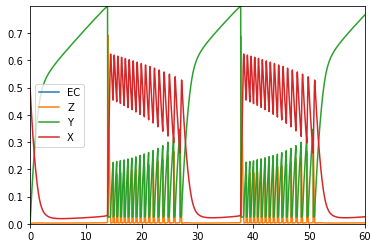

In [12]:
def runExperiment(parameter_dct=None, model=MODEL, is_plot=True,
                  start_time=START_TIME, end_time=END_TIME, num_point=NUM_POINT):
    """
    Run a simulation experiment making the parameter substations.
    
    Parameters
    ----------
    parameter_dct: dict (key: parameter; value: value to assign)
    model: str (antimony model)
    isPlot: bool
    start_time: float (beginning of simulation)
    end_time: float (end of simulation)
    num_point: number of points in the simulation
    
    Returns
    -------
    pd.DataFrame (index: time; columns: floating species)
    """
    if parameter_dct is None:
        parameter_dct = {}
    #
    roadrunner = te.loada(model)
    for parameter, value in parameter_dct.items():
        roadrunner[parameter] = value
    df = arrToDF(roadrunner.simulate(start_time, end_time, num_point))
    #import pdb; pdb.set_trace()
    max_y = df.max().max()
    #
    figure, ax = plt.subplots(1)
    title = " ".join(["%s: %1.2f" % (k, v) for k, v in parameter_dct.items()])
    for col in df.columns:
        _ = ax.plot(df.index, df[col])
    _ = ax.set_title(title)
    _ = ax.set_xlim([start_time, end_time])
    _ = ax.set_ylim([0, max_y])
    _ = plt.legend(df.columns)
    #ROADRUNNER.plot(data, title=title, ax=ax)
    if not is_plot:
        _ = plt.close()
    return df

# Test
data = runExperiment({}, is_plot=True)
assert(len(data) > 0)
print("OK!")

In [13]:
def getResponse(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: species
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    return calculatePeakFrequency(molecule, df)

In [14]:
LEVELS = [v for v in range(11)]
def runStudy(levels=LEVELS, isProgressReport=True, isTFC=True):
    """
    Runs experiments searching for combinations of parameter values that statisfy:
    1. ``Y`` has oscillations of at least 1.5 Hz during the times 5 sec to 30 sec.
    2. The "amplitude" (Fourier coefficient) for the oscillations is at least 2.5.
    3. All concentrations of the chemical species are non-negative in the simulation.
    
    Parameters
    ----------
    levels: list-float
        levels (values) to use for initial values of chemical species
    isProgressReport: bool
        reports initial values of parameters being tested
    isTFC: bool
        two factor in combination design
        
    Returns
    -------
    int: number of experiments run
    """
    # One factor at a time study
    numExperiment = 0
    AMPLITUDE_MIN = 50
    FREQUENCY_MIN = 1.3
    done = False
    parameterItr = itertools.product(PARAMETERS, PARAMETERS)
    for parameter1, parameter2 in parameterItr:
        if parameter1 == parameter2:
            continue
        if done:
            break
        levelItr = itertools.product(levels, levels)
        for level1, level2 in levelItr:
            parameterDct = {parameter1: level1}
            if isTFC:
                parameterDct[parameter2] = level2
            df = runExperiment(parameterDct, is_plot=False)
            for col in df.columns:
                trues = [v >= 0 for v in df[col]]
                if not all(trues):
                    continue
            numExperiment += 1
            freq, ampl = getResponse("Y", df)
            if isProgressReport:
                print("%s: %2.1f, %s: %2.1f, freq: %2.2f, ampl: %2.2f " 
                      % (parameter1, level1, parameter2, level2, freq, ampl))
            if (ampl >= AMPLITUDE_MIN) and (freq >= FREQUENCY_MIN):
                _ = runExperiment(parameterDct, is_plot=True)
                done = True
                break
    return numExperiment
                
# Tests
numExperiment = runStudy(levels=[0, 0.5], isProgressReport=False)
assert(numExperiment > 10)
print("OK!")

OK!


# Studies and Analysis

By choosing a combination of factors at the low and high end of change, the combinatorics were modest.
Changes two factors in combination was sufficient to find a combination of values
that met the requirements of the problem.

X: 0.1, Y: 0.1, freq: 1.38, ampl: 62.95 


1

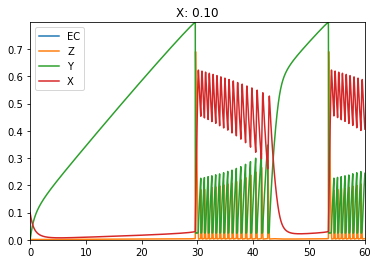

In [15]:
runStudy(levels=[0.1, 0.2, .9, 1], isProgressReport=True, isTFC=False)

Since we failed to find a combination of levels that meets our criteria, we now use TFC.

We found values that meet our requirements, including that all concentrations are non-negative.